In [1]:
import pandas as pd
import numpy as np
import requests
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
plt.style.use("seaborn")

/home/pnietoramos/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Defining Features and Classifier

In [2]:
df_all = pd.read_csv("Trees_clean.csv", index_col=False)

In [3]:
df_all.head(1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type
0,2596,51,3,258,0,510,221,232,148,6279,5,29


In [4]:
X = df_all.drop("Cover_Type",axis=1)
y = df_all["Cover_Type"]

In [5]:
#Splitting the set (test = 0.3) in a stratified manner
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30,stratify=y, random_state=4444)

In [6]:
#scaling the features
sca = StandardScaler()
X_train_sca = sca.fit_transform(X_train)
X_test_sca = sca.transform(X_test);

In [7]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [8]:
def grid_estimator(estimator, param_grid, X_train, y_train, X_test, y_test, cv=5):
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, n_jobs=1)
    grid.fit(X_train, y_train)
    print("Accuracy training: " + str(grid.best_score_))
    y_pred = grid.predict(X_test)
    print("Accuracy test: " + str(accuracy_score(y_pred,y_test)))
    print(grid.best_estimator_)


In [9]:
def conf_trees(y, y_pred):
    trees_confusion = confusion_matrix(y, y_pred)
    plt.figure(dpi=180)
    sns.heatmap(trees_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
               xticklabels=["1","2","3","4","5","6","7"],
               yticklabels=["1","2","3","4","5","6","7"] , fontsize =30);
    plt.xlabel('prediction')
    plt.ylabel('actual');

### Trying Random Forest Classifier with default values 

In [10]:
param_grid = {}
grid_estimator(RandomForestClassifier(), param_grid, X_train_sca, y_train, X_test_sca, y_test)

Accuracy training: 0.9398020201225449
Accuracy test: 0.945675371764274
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [12]:
rf = RandomForestClassifier()
rf.fit(X_train_sca, y_train)
y_pred = rf.predict(X_test_sca)
feature_viewer = {}
for col, score in zip(X.loc[:,:].columns, rf.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Elevation                             0.290759
Aspect                                0.043264
Slope                                 0.029667
Horizontal_Distance_To_Hydrology      0.064895
Vertical_Distance_To_Hydrology        0.057473
Horizontal_Distance_To_Roadways       0.131102
Hillshade_9am                         0.039375
Hillshade_Noon                        0.042189
Hillshade_3pm                         0.037083
Horizontal_Distance_To_Fire_Points    0.124589
Soil_Type                             0.139606
dtype: float64

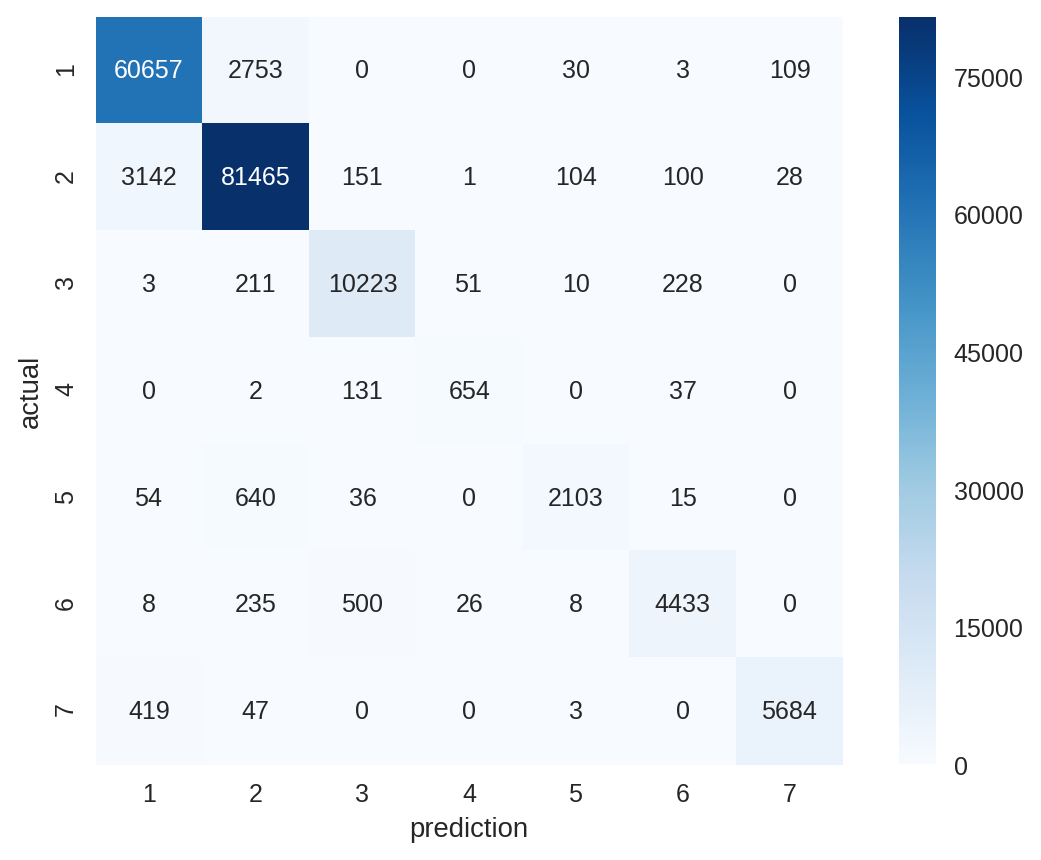

In [16]:
conf_trees(y_test, y_pred)

In [17]:
print("Recall for cover:")
for i in range(7):
    print("Type " + str(i+1)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i+1)])))

Recall for cover:
Type 1:95.4446752265861
Type 2:95.85132543445776
Type 3:95.31046056311766
Type 4:79.36893203883496
Type 5:73.84129213483146
Type 6:85.08637236084454
Type 7:92.37770193401593


In [18]:
print("Precision for cover:")
for i in range(7):
    print("Type " + str(i+1)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i+1)])))

Precision for cover:
Type 1:94.35931739340106
Type 2:95.44479983128888
Type 3:92.59125079250067
Type 4:89.34426229508196
Type 5:93.13551815766165
Type 6:92.04734219269103
Type 7:97.64645249957051


### Selecting features with importance >0.05 

In [12]:
col_in = ["Elevation","Horizontal_Distance_To_Roadways","Horizontal_Distance_To_Fire_Points", "Soil_Type",
          "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_train_in = X_train[col_in]
X_test_in = X_test[col_in]
sca = StandardScaler()
X_train_in_sca = sca.fit_transform(X_train_in)
X_test_in_sca = sca.transform(X_test_in);

In [21]:
rf = RandomForestClassifier()
rf.fit(X_train_in_sca, y_train)
y_pred = rf.predict(X_test_in_sca)
feature_viewer = {}
for col, score in zip(X.loc[:,:].columns, rf.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Elevation                           0.312044
Aspect                              0.187920
Slope                               0.165716
Horizontal_Distance_To_Hydrology    0.169374
Vertical_Distance_To_Hydrology      0.081746
Horizontal_Distance_To_Roadways     0.083201
dtype: float64

In [22]:
print("Recall for cover:")
for i in range(7):
    print("Type " + str(i+1)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i+1)])))

Recall for cover:
Type 1:96.19366817724068
Type 2:96.10429339577132
Type 3:94.78836472123811
Type 4:81.18932038834951
Type 5:78.3005617977528
Type 6:84.62571976967371
Type 7:93.20656590281163


In [23]:
print("Precision for cover:")
for i in range(7):
    print("Type " + str(i+1)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i+1)])))

Precision for cover:
Type 1:94.87103882802073
Type 2:96.10203193204146
Type 3:92.68848573251891
Type 4:86.54592496765848
Type 5:92.5695309256953
Type 6:91.96912807676262
Type 7:96.7442645074224


### Hyperparameters tunning with selected features

In [10]:
col_in = ["Elevation","Horizontal_Distance_To_Roadways","Horizontal_Distance_To_Fire_Points", "Soil_Type",
          "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_in = X[col_in]
X_train_in = X_train[col_in]
X_test_in = X_test[col_in]
sca = StandardScaler()
X_train_in_sca = sca.fit_transform(X_train_in)
X_test_in_sca = sca.transform(X_test_in);

In [13]:
param_grid = {'n_estimators': [10,100], 'max_depth': [50,100,200], 'max_leaf_nodes':[1000000,10000000]}
grid_estimator(RandomForestClassifier(), param_grid, X_train_in_sca, y_train, X_test_in_sca, y_test)

Accuracy training: 0.9572961436706433
Accuracy test: 0.9616761520102809
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=1000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [11]:
param_grid = {'n_estimators': [100,200], 'max_depth': [50], 'max_leaf_nodes':[500000, 1000000]}
grid_estimator(RandomForestClassifier(), param_grid, X_train_in_sca, y_train, X_test_in_sca, y_test)

Accuracy training: 0.9576157833138271
Accuracy test: 0.9622728107214981
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=1000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [12]:
param_grid = {'n_estimators': [200,500,1000], 'max_depth': [10,20,30,40,50], 'max_leaf_nodes':[800000, 1000000, 2000000]}
grid_estimator(RandomForestClassifier(), param_grid, X_train_in_sca, y_train, X_test_in_sca, y_test)

KeyboardInterrupt: 

### Visualizing results for the best model with selected features

In [10]:
def conf_trees(y, y_pred):
    trees_confusion = confusion_matrix(y, y_pred)
    plt.figure(dpi=180)
    sns.heatmap(trees_confusion, cmap=plt.cm.Blues, annot=True,  annot_kws={"size": 10}, square=True, fmt='d',
               xticklabels=["1","2","3","4","5","6","7"],
               yticklabels=["1","2","3","4","5","6","7"]);
    plt.tick_params(axis="both", labelsize=14)
    plt.xlabel('prediction', fontsize = 14)
    plt.ylabel('actual', fontsize = 14);

In [11]:
col_in = ["Elevation","Horizontal_Distance_To_Roadways","Horizontal_Distance_To_Fire_Points", "Soil_Type",
          "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_in = X[col_in]
X_train_in = X_train[col_in]
X_test_in = X_test[col_in]
sca = StandardScaler()
X_train_in_sca = sca.fit_transform(X_train_in)
X_test_in_sca = sca.transform(X_test_in);

In [12]:
rf = RandomForestClassifier(max_leaf_nodes=1000000, max_depth=50, n_estimators=200)
rf.fit(X_train_in_sca, y_train)
y_pred = rf.predict(X_test_in_sca)
y_pred_train = rf.predict(X_train_in_sca)

In [13]:
print(accuracy_score(y_pred_train,y_train))
print(accuracy_score(y_pred,y_test))

1.0
0.9623129704424453


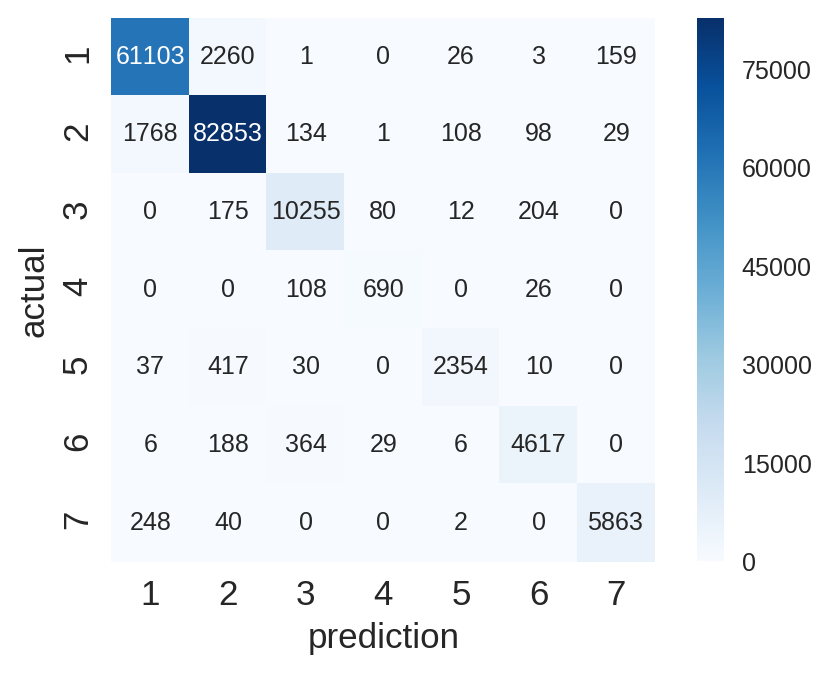

In [14]:
conf_trees(y_test, y_pred)

In [15]:
print("Recall for cover:")
for i in range(7):
    print("Type " + str(i+1)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i+1)])))

Recall for cover:
Type 1:96.14646273917423
Type 2:97.4844395288913
Type 3:95.60880104419168
Type 4:83.7378640776699
Type 5:82.65449438202248
Type 6:88.61804222648752
Type 7:95.28685194214205


In [16]:
print("Precision for cover:")
for i in range(7):
    print("Type " + str(i+1)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i+1)])))

Precision for cover:
Type 1:96.74012855831037
Type 2:96.41581231889961
Type 3:94.15167095115682
Type 4:86.25
Type 5:93.85964912280701
Type 6:93.12222670431626
Type 7:96.89307552470666


### Trying oversampling (SMOTE)

In [17]:
col_in = ["Elevation","Horizontal_Distance_To_Roadways","Horizontal_Distance_To_Fire_Points", "Soil_Type",
          "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_in = X[col_in]
X_train_in = X_train[col_in]
X_test_in = X_test[col_in]
X_test_in = X_test[col_in]
sca = StandardScaler()
X_train_in_sca = sca.fit_transform(X_train_in)
X_test_in_sca = sca.transform(X_test_in);

In [18]:
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train_in_sca,y_train)

In [19]:
rf = RandomForestClassifier(max_leaf_nodes=1000000, max_depth=50, n_estimators=200)
rf.fit(X_smoted, y_smoted)
y_pred = rf.predict(X_test_in_sca)
y_pred_train = rf.predict(X_smoted)

In [20]:
print(accuracy_score(y_pred_train,y_smoted))
print(accuracy_score(y_pred,y_test))

1.0
0.9636267670277217


In [21]:
print("Recall for cover:")
for i in range(7):
    print("Type " + str(i+1)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i+1)])))

Recall for cover:
Type 1:96.45644511581068
Type 2:96.68788459954584
Type 3:95.89781838523214
Type 4:87.74271844660194
Type 5:91.92415730337079
Type 6:93.03262955854127
Type 7:97.74093937916463


In [22]:
print("Precision for cover:")
for i in range(7):
    print("Type " + str(i+1)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i+1)])))

Precision for cover:
Type 1:96.76859204066491
Type 2:97.31304399313163
Type 3:94.38429069554047
Type 4:85.76512455516014
Type 5:86.74618952948973
Type 6:89.59334565619224
Type 7:94.81317988333596


### Training with the whole set

In [23]:
col_in = ["Elevation","Horizontal_Distance_To_Roadways","Horizontal_Distance_To_Fire_Points", "Soil_Type",
          "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_in = X[col_in]
sca = StandardScaler()
X_in_sca = sca.fit_transform(X_in);

In [24]:
rf = RandomForestClassifier(max_leaf_nodes=1000000, max_depth=50, n_estimators=200)
rf.fit(X_in_sca, y)
y_pred = rf.predict(X_in_sca)

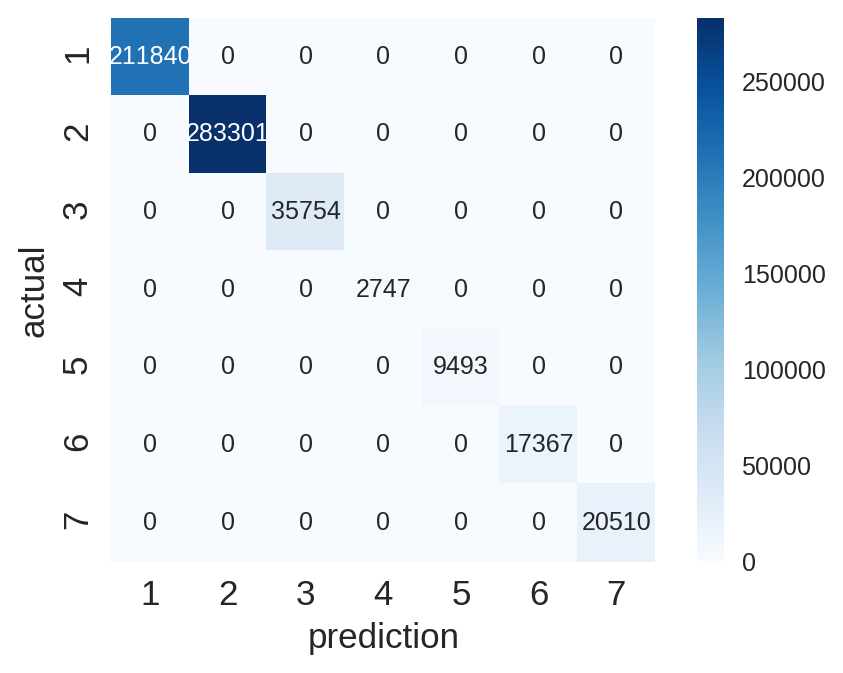

In [25]:
conf_trees(y, y_pred)

In [26]:
print("Recall for cover:")
for i in range(7):
    print("Type " + str(i+1)+ ":" + str(100 * confusion_matrix(y, y_pred)[i,i]/len(y[y==(i+1)])))

Recall for cover:
Type 1:100.0
Type 2:100.0
Type 3:100.0
Type 4:100.0
Type 5:100.0
Type 6:100.0
Type 7:100.0


In [27]:
print("Precision for cover:")
for i in range(7):
    print("Type " + str(i+1)+ ":" + str(100 * confusion_matrix(y, y_pred)[i,i]/len(y_pred[y_pred==(i+1)])))

Precision for cover:
Type 1:100.0
Type 2:100.0
Type 3:100.0
Type 4:100.0
Type 5:100.0
Type 6:100.0
Type 7:100.0


### Now without the distance to fire points

In [10]:
col_in_wf = ["Elevation","Horizontal_Distance_To_Roadways", "Soil_Type",
          "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_train_in_wf = X_train[col_in_wf]
X_test_in_wf = X_test[col_in_wf]
sca = StandardScaler()
X_train_in_wf_sca = sca.fit_transform(X_train_in_wf)
X_test_in_wf_sca = sca.transform(X_test_in_wf);

In [11]:
rf = RandomForestClassifier(max_leaf_nodes=1000000, max_depth=50, n_estimators=200)
rf.fit(X_train_in_wf_sca, y_train)
y_pred = rf.predict(X_test_in_wf_sca)

In [12]:
print("Recall for cover:")
for i in range(7):
    print("Type " + str(i+1)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i+1)])))

Recall for cover:
Type 1:91.59428499496475
Type 2:94.47941546752008
Type 3:91.61849710982659
Type 4:79.00485436893204
Type 5:71.875
Type 6:75.73896353166987
Type 7:90.73622623110678


In [13]:
print("Precision for cover:")
for i in range(7):
    print("Type " + str(i+1)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i+1)])))

Precision for cover:
Type 1:92.71175102729907
Type 2:92.58823665063936
Type 3:89.67877349881365
Type 4:82.50950570342205
Type 5:88.88406426400347
Type 6:82.48327759197325
Type 7:93.72167198254155
